# Part #07: Transfer Learning & Tensorhub


TensorFlow 2.0 Tutorial by IUST

*   Last Update: Feb 2020
*   Official Page: https://github.com/iust-deep-learning/tensorflow-2-tutorial





---




Please run the following cell before going through the rest of the tutorial.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D , Dense , Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions
import urllib

## 1.Use a pre-trained model
---
A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. Accordingly, due to the computational cost of training such models, it is common practice to import and use models from published literature (e.g. VGG, Inception, MobileNet). A comprehensive review of pre-trained models’ performance on computer vision problems using data from the ImageNet (Deng et al. 2009) challenge is presented by Canziani et al.

In [0]:
vgg16_model = VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
mug_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS1rIQtM5FnadDVK4HxTM5wOtbJOv4MZzG4tIRzUU2WIHKHG4iu'
urllib.request.urlretrieve (mug_url, "mug.jpg")

('mug.jpg', <http.client.HTTPMessage at 0x7fb1f314cf98>)

In [0]:
# load an image from file
image = load_img('mug.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
predict = vgg16_model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(predict)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

coffee_mug (83.83%)


## 2.Transfer Learning
Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

Transfer Learning has 2 approches : 


1.   Feature Extraction
2.   Fine Tunning



Again we use VGG16 model but this time we do not need Dense layers in VGG16 , because it is better
to train dense layers with our dataset

In [0]:
vgg16_model = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature Extraction 

When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

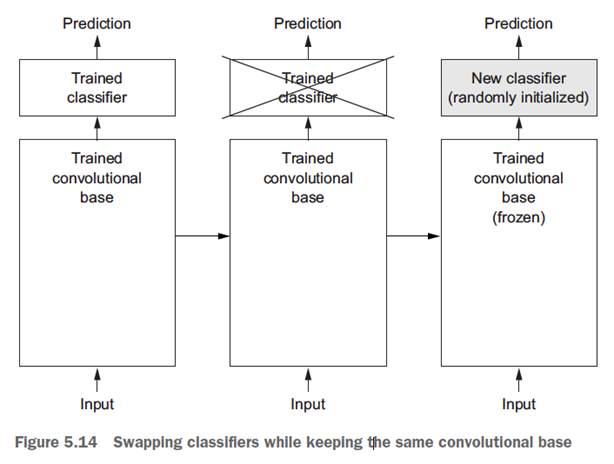

In [0]:
x = vgg16_model.output
x = Flatten()(x)
x = Dense(128)(x)
predictions = Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs=vgg16_model.input, outputs=predictions)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

Due to the fact that training VGG16 model is costly , we freez it's parameters and we train our layers

In [0]:
vgg16_model.trainable = False
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

Download the data from:
https://www.kaggle.com/c/dogs-vs-cats/data

then save train dataset in /content/train/

In [0]:
import os, shutil
# path to the directory where the original dataset was uncompressed
original_dataset_dir = '/content/train/'

# directory where you’ll store your smaller dataset
base_dir = '/content/train/'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

# directory containing cat training images
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.isdir(train_cats_dir):
    os.mkdir(train_cats_dir)

# directory containing dog training images
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.isdir(train_dogs_dir):
    os.mkdir(train_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)


fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=20,class_mode='binary')
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=5)

Found 2000 images belonging to 2 classes.
  ...
    to  
  ['...']
Train for 100 steps
Epoch 1/5
100/100 [==============================] - 8s 79ms/step - loss: 0.7787 - acc: 0.8090
Epoch 2/5
100/100 [==============================] - 7s 74ms/step - loss: 0.2044 - acc: 0.9325
Epoch 3/5
100/100 [==============================] - 8s 76ms/step - loss: 0.0982 - acc: 0.9595
Epoch 4/5
100/100 [==============================] - 8s 77ms/step - loss: 0.0651 - acc: 0.9745
Epoch 5/5
100/100 [==============================] - 7s 72ms/step - loss: 0.0363 - acc: 0.9915


## Fine Tunning 
 
To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on

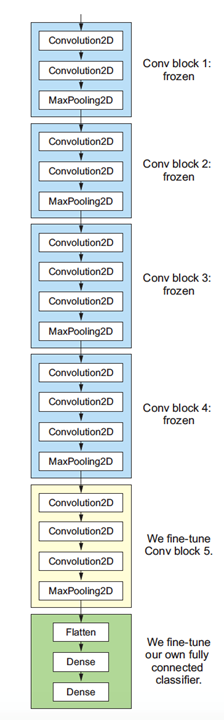


*   Add your custom network on top of an already-trained base network
*   Freeze the base network.
*   Train the part you added.
*   Unfreeze some layers in the base network.
*   Jointly train both these layers and the part you added.









In [0]:
vgg16_model = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))
x = vgg16_model.output
x = Flatten()(x)
x = Dense(128)(x)
predictions = Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs=vgg16_model.input, outputs=predictions)

At fisrt we freez all vgg16 layers and train the model 

In [0]:
vgg16_model.trainable = False
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=2)

  ...
    to  
  ['...']
Train for 100 steps
Epoch 1/2
100/100 [==============================] - 8s 77ms/step - loss: 0.6406 - acc: 0.8235
Epoch 2/2
100/100 [==============================] - 7s 70ms/step - loss: 0.2432 - acc: 0.9105


Now we try to unfreez some layers

In [0]:
for layer in model.layers[-8:]:
  layer.trainable = True
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

In [0]:
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=2)

  ...
    to  
  ['...']
Train for 100 steps
Epoch 1/2
100/100 [==============================] - 7s 73ms/step - loss: 0.1356 - acc: 0.9465
Epoch 2/2
100/100 [==============================] - 7s 71ms/step - loss: 0.1203 - acc: 0.9550


## 3.Transfer Learning using Tensor Hub

In [0]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions
import urllib

First of all we have to download our network with tensorhub 

you can see networks in https://tfhub.dev/s?q=tf2

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=(IMAGE_SHAPE)+(3,))
])

In [0]:
mug_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS1rIQtM5FnadDVK4HxTM5wOtbJOv4MZzG4tIRzUU2WIHKHG4iu'
urllib.request.urlretrieve (mug_url, "mug.jpg")

# load an image from file
image = load_img('mug.jpg', target_size=(224,224))
# convert the image pixels to a numpy array
image = img_to_array(image)
image = image/255
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

predicted = classifier.predict(image)
predicted_class = tf.math.argmax(predicted[0])
print(predicted_class)
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels[predicted_class]

tf.Tensor(505, shape=(), dtype=int64)


'coffee mug'

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))
output = feature_extractor_layer(image)
output.shape  # output of layers without dense layers 

TensorShape([1, 1280])

## Excercise #1 :

Using what you have learned today train a network ok dog vs cats dataset

In [0]:
""" you can use pre-trained model which we used in last section and add your dense layers """




## 4. References
---



1.   Created by bardia karmi : Feb2020
2.   https://www.tensorflow.org/tutorials/images/transfer_learning
3.   https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub








